1. Реализуйте минимум 3 кастомные аугментации (например, случайное размытие, случайная перспектива, случайная яркость/контрастность).
2. Примените их к изображениям из train.
3. Сравните визуально с готовыми аугментациями из extra_augs.py.

In [55]:
import torchvision.transforms.functional as F
from PIL import ImageFilter

# Случайное размытие
class RandomBlur:
    def __init__(self, p=0.5, radius_range=(0.5, 2.0)):
        self.p = p
        self.radius_range = radius_range

    def __call__(self, img):
        if random.random() < self.p:
            radius = random.uniform(*self.radius_range)
            return img.filter(ImageFilter.GaussianBlur(radius))
        return img

In [56]:
import numpy as np
from PIL import Image

# Случайная перспертивная трансформация
class RandomPerspective:
    def __init__(self, p=0.5, distortion_scale=0.3):
        self.p = p
        self.distortion_scale = distortion_scale

    def __call__(self, img):
        if random.random() < self.p:
            w, h = img.size
            points = np.array([
                [0, 0],
                [w-1, 0],
                [w-1, h-1],
                [0, h-1]
            ], dtype=np.float32)
            
            max_offset = self.distortion_scale * min(w, h)
            new_points = points + np.random.uniform(
                -max_offset, max_offset, size=points.shape)
            
            # Расчет коэффициентов перспективы
            coeffs = self._find_perspective_coeffs(points, new_points)
            return img.transform(img.size, Image.PERSPECTIVE, coeffs, Image.BICUBIC)
        return img

    # Вычисление коэффициентов перспективной трансформации.
    def _find_perspective_coeffs(self, orig_points, new_points):
        A = []
        B = []
        for (x, y), (X, Y) in zip(orig_points, new_points):
            A.append([x, y, 1, 0, 0, 0, -X*x, -X*y])
            A.append([0, 0, 0, x, y, 1, -Y*x, -Y*y])
            B.append(X)
            B.append(Y)
        A = np.array(A, dtype=np.float32)
        B = np.array(B, dtype=np.float32)
        coeffs = np.linalg.lstsq(A, B, rcond=None)[0]
        return coeffs.tolist()

In [57]:
#  Случайная регулировка яркости и контраста
class RandomBrightnessContrast:
    def __init__(self, brightness=0.3, contrast=0.3, p=0.5):
        self.brightness = brightness
        self.contrast = contrast
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            # Регулировка яркости
            enhancer = ImageEnhance.Brightness(img)
            brightness_factor = 1 + random.uniform(-self.brightness, self.brightness)
            img = enhancer.enhance(brightness_factor)
            
            # Регулировка контраста
            enhancer = ImageEnhance.Contrast(img)
            contrast_factor = 1 + random.uniform(-self.contrast, self.contrast)
            img = enhancer.enhance(contrast_factor)
        return img

Используется изображение класса: Гароу


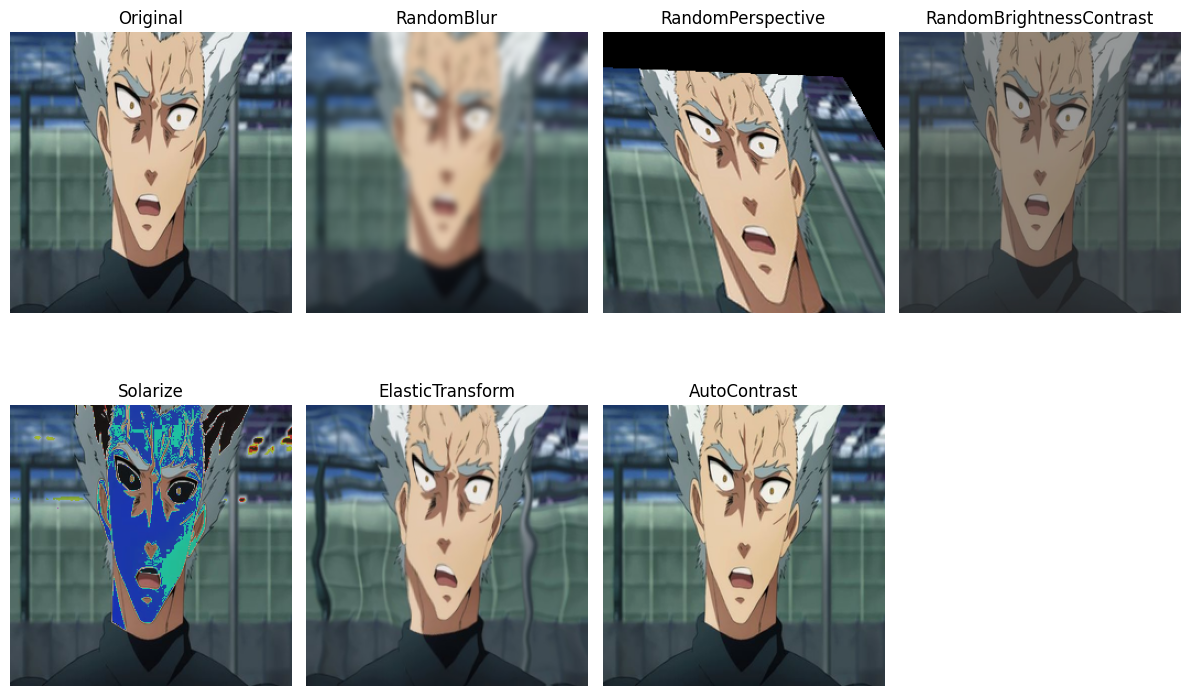

In [65]:
from datasets import CustomImageDataset
from extra_augs import AddGaussianNoise, CutOut, Solarize, AutoContrast, ElasticTransform
from utils import show_multiple_augmentations
from torchvision import transforms
import random
from PIL import ImageEnhance
import matplotlib.pyplot as plt

root = 'data/train'
dataset = CustomImageDataset(root, transform=None, target_size=(256, 256))
class_names = dataset.get_class_names()

original_img, label = dataset[2]
print(f"Используется изображение класса: {class_names[label]}")

# Применение кастомных аугментаций
custom_augs = [
    ("RandomBlur", RandomBlur(p=1.0, radius_range=(2.0, 5.0))),
    ("RandomPerspective", RandomPerspective(p=1.0, distortion_scale=0.3)),
    ("RandomBrightnessContrast", RandomBrightnessContrast(p=1.0, brightness=0.5, contrast=0.5))
]

custom_results = []
for name, aug in custom_augs:
    custom_results.append(transforms.ToTensor()(aug(original_img.copy())))

# Применение готовых аугментаций
ready_augs = [
    ("Solarize", Solarize(threshold=192)),
    ("ElasticTransform", ElasticTransform(p=1, alpha=80, sigma=10)),
    ("AutoContrast", AutoContrast())
]

# Конвертация в тензор
original_tensor = transforms.ToTensor()(original_img)
ready_results = [aug(original_tensor.clone()) for name, aug in ready_augs]


# Визуализация результатов
plt.figure(figsize=(12, 8))

# Оригинальное изображение
plt.subplot(2, 4, 1)
plt.imshow(original_img)
plt.title("Original")
plt.axis('off')

# Кастомные аугментации
for i, (img, (name, _)) in enumerate(zip(custom_results, custom_augs)):
    plt.subplot(2, 4, i+2)
    plt.imshow(img.permute(1, 2, 0).numpy())
    plt.title(name)
    plt.axis('off')

# Готовые аугментации
for i, (img, (name, _)) in enumerate(zip(ready_results, ready_augs)):
    plt.subplot(2, 4, i+5)
    plt.imshow(img.permute(1, 2, 0).numpy())
    plt.title(name)
    plt.axis('off')

plt.tight_layout()
plt.show()